In [46]:
#dataset: https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

# Faster RCNN 
# Mask RCNN

In [1]:
%matplotlib inline
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvisutils import engine, utils
from easyimages import EasyImageList
from easyimages.utils import vis_image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvisutils.engine import train_one_epoch, evaluate
from torchvisutils import utils
import torchvisutils.transforms as T
import itertools
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
    
def get_fpn_predictions(model, images, targets):

    device = 'cuda'
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    images, targets = model.transform(images, targets)

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([('0', features)])
    boxes, losses = model.rpn(images, features, targets)
    
    return boxes, losses
    
ds = '/home/i008/PennFudanPed'
dataset = PennFudanDataset(ds)
dataset[0][0]

# use our dataset and defined transformations
dataset = PennFudanDataset(ds, get_transform(train=True))
dataset_test = PennFudanDataset(ds, get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [2]:

def get_instance_segmentation_model(num_classes, pretrained=True):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

it = iter(data_loader_test)
index = 10
images, targets = next(itertools.islice(it, index, None))

In [3]:
def get_fpn_predictions(model, images, targets):

    device = 'cuda'
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    images, targets = model.transform(images, targets)

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([('0', features)])
    boxes, losses = model.rpn(images, features, targets)
    
    return boxes, losses, images


# visualize FPN outputs for a pretrained/not pretrained network network

In [9]:
model_pretrained = get_instance_segmentation_model(2, pretrained=True)
model_pretrained.eval()

boxes, losses, tr_images = get_fpn_predictions(model_pretrained.cuda(), images, targets)
img = np.moveaxis(invTrans(tr_images.tensors[0]).cpu().numpy(), 0, 2)
f = vis_image(img,boxes=[b.cpu().numpy() for b in boxes[0]][:30], 
          box_order='tlbr')

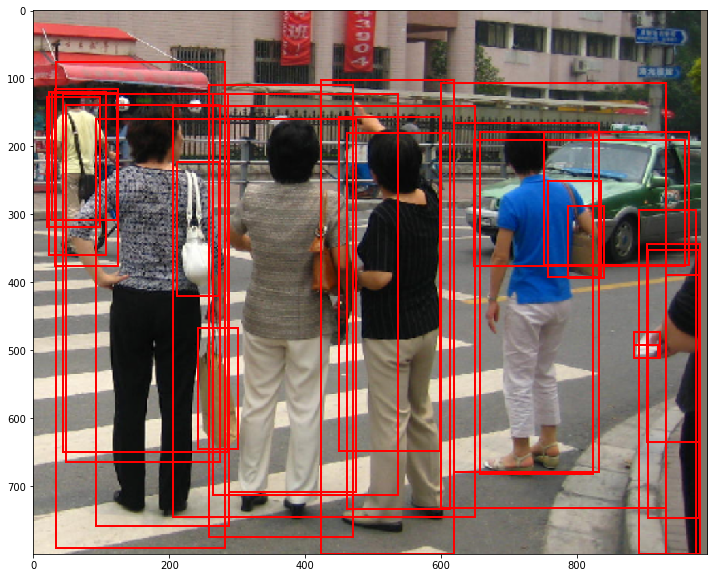

In [10]:
f

In [6]:
model_not_pretrained = get_instance_segmentation_model(2, pretrained=False)
model_not_pretrained.eval()
boxes, losses, tr_images = get_fpn_predictions(model_not_pretrained.cuda(), images, targets)
img = np.moveaxis(invTrans(tr_images.tensors[0]).cpu().numpy(), 0, 2)
f = vis_image(
    img,boxes=[b.cpu().numpy() for b in boxes[0]][:30], 
    box_order='tlbr')

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes, pretrained=True)
# move model to the right device
model.to(device)
model.train()

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [8]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

AttributeError: module 'utils' has no attribute 'MetricLogger'

In [ ]:
# pick one image from the test set
img, _ = dataset_test[3]
# put the model in evaluation mode


In [ ]:
model.eval()
predictions = model([images[0].cuda()])

In [ ]:
f = vis_image(img, prediction[0]['boxes'][:500])